<a href="https://www.kaggle.com/code/angelchaudhary/outlier-handling-removal-vs-capping-vs-transfrmrs?scriptVersionId=292590991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A Practical Comparison of Outlier Removal, Capping, and Transformation in Machine Learning Models

# Introduction  
 
Real-world datasets are messy. Extreme values outliers can silently distort distributions, bias model learning, and mislead evaluation metrics. The core problem is simple but critical:  
**How should we handle outliers so that models learn patterns, not noise?**  
Removing them might lose valuable information, keeping them might hurt performance, and blindly transforming them might hide important signals.

Outlier handling is often treated as a checkbox step in preprocessing, not a design decision. In practice, different techniques can lead to very different model behaviors, even on the same dataset.  
This case study aims to move beyond theory and answer a practical question:  
> *Which outlier-handling technique works best—and when?*  

## Approach  
We'll take an experiment-first approach:

1. **Understand the data** and identify outliers using statistical methods and visual cues  
2. Apply three common strategies:
   - **Outlier Removal** – dropping extreme values  
   - **Outlier Capping** – limiting values using IQR/percentiles  
   - **Data Transformation** – reducing skewness (log, power transforms)  
3. **Train the same model** on each processed dataset  
4. **Compare performance, stability, and error metrics**  
5. Draw practical conclusions on **when to use what—and why**

The goal isn’t to declare a universal winner, but to learn **how different choices change model behavior**.

# LET'S DO IT!!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExeXhhZXFqN284dXF3MHgxbmlic3J5M2Y1d2d3dzhncXE2bTVmd2ZrYiZlcD12MV9naWZzX3NlYXJjaCZjdD1n/T3rgaqd1vT6idUS12Q/giphy.gif)

## Dataset Overview

The **California Housing Prices** dataset contains information collected from the 1990 California census, aimed at predicting **median house values** across different regions. Each row represents a housing block group and includes geographical, demographic, and housing-related features.

The dataset consists of **20,640 observations** with a mix of numerical and categorical variables. Several numerical features such as `total_rooms`, `population`, and `median_income` exhibit **strong right-skewness and extreme values**, making this dataset especially suitable for studying **outlier handling techniques**. The target variable, `median_house_value`, is continuous and capped at an upper limit, offering an interesting real-world constraint to analyze how outliers influence regression models. Overall, the dataset is clean, realistic, and well suited for comparing **outlier removal, capping, and transformation** strategies in a regression setting.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kallolnath1/california-housing-prices-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/california-housing-prices-dataset


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/california-housing-prices-dataset/housing.csv")
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY


In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [19]:
df[features].isna().sum()

total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
housing_median_age      0
dtype: int64

In [20]:
df_dropped = df.drop(columns=["total_bedrooms"])
df_iqr_dropped = df_iqr_removed.drop(columns=["total_bedrooms"])

## 1. Identify and Visualize Outliers

Before applying any outlier-handling technique, we first need to **understand where outliers exist and how severe they are**.  
Visualizing distributions helps us decide **which features actually need treatment** and which can be left untouched.

In this step, we:
- Select key numerical features prone to outliers
- Visualize their distributions using boxplots and histograms

In [22]:
# Selecting numerical features prone to outliers
outlier_features = ["total_rooms","population","households","median_income"]

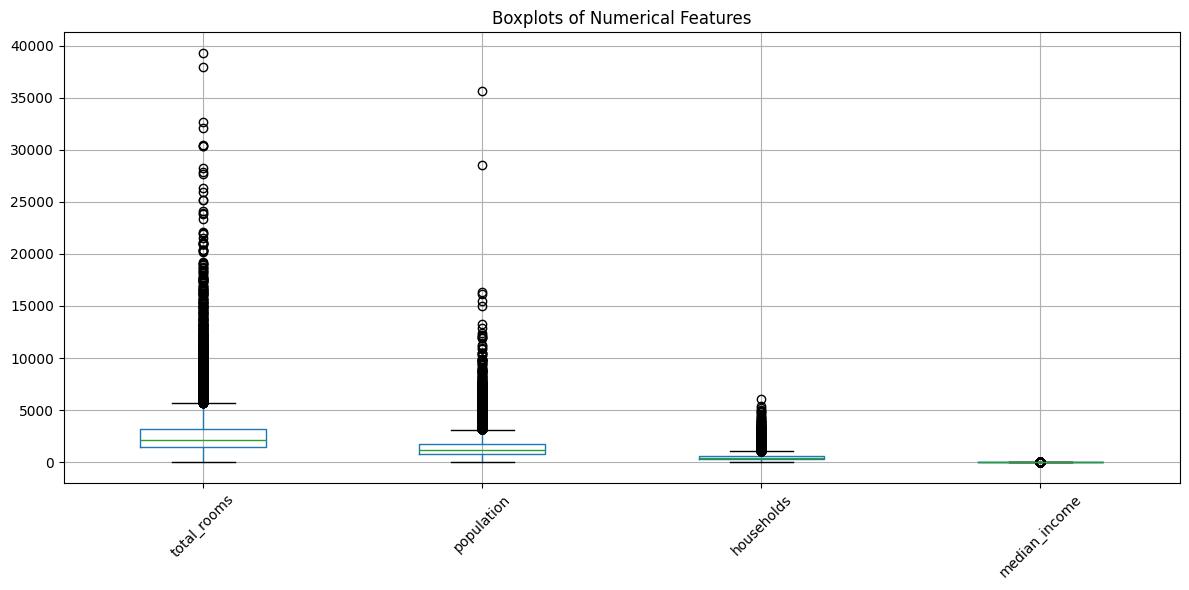

In [23]:
# boxplot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df[outlier_features].boxplot(rot=45)
plt.title("Boxplots of Numerical Features")
plt.tight_layout()
plt.show()

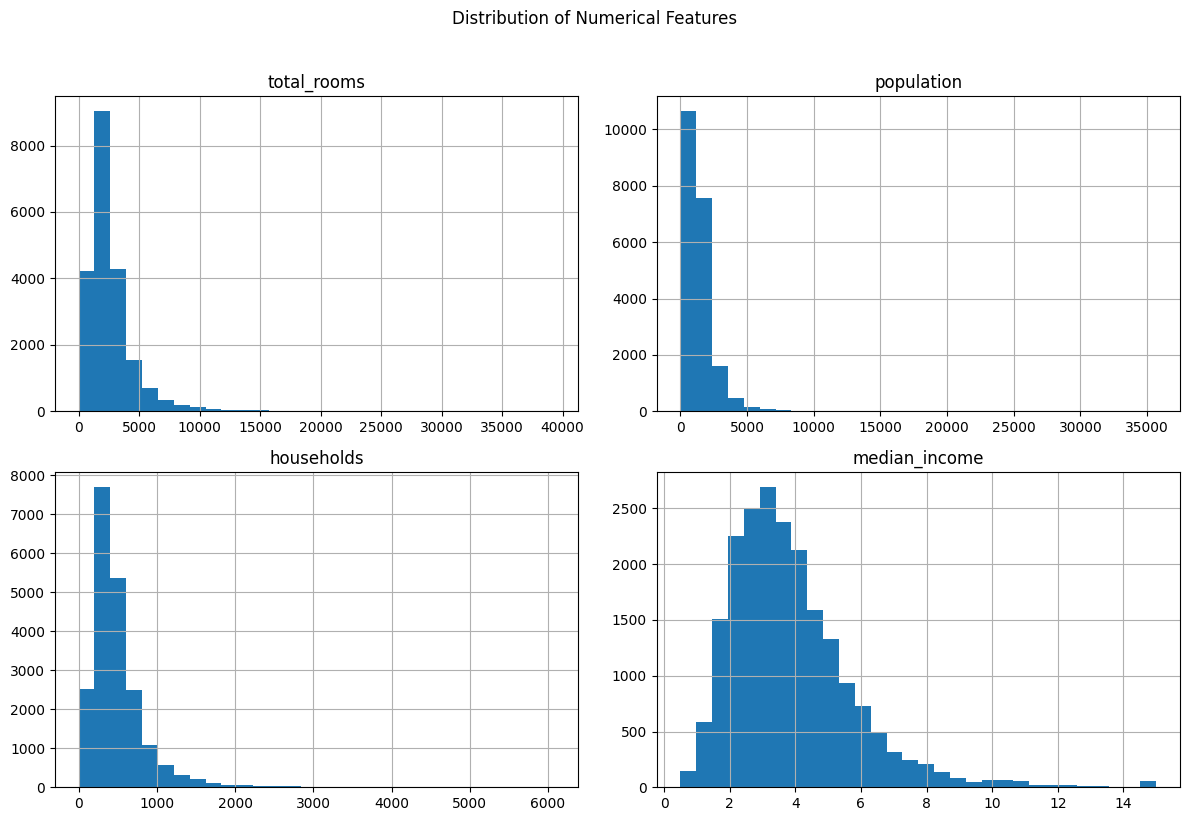

In [24]:
# to understand skewness
df[outlier_features].hist(figsize=(12, 8),bins=30)
plt.suptitle("Distribution of Numerical Features", y=1.02)
plt.tight_layout()
plt.show()

### Observations from Outlier Visualization

- All selected features exhibit **right-skewed distributions**, indicating the presence of extreme high-value observations.
- **`total_rooms`** and **`population`** show a large number of extreme outliers, with values far beyond the upper quartile, suggesting high variance across regions.
-  **`households`** follow a similar pattern, though with slightly less extreme dispersion.
- Boxplots reveal a **dense cluster of outliers**, not just isolated points, indicating that these are not data errors but valid high-density housing areas.
- **`median_income`** shows moderate skewness with a clear upper cap, making it a strong candidate for **transformation rather than removal**.
- The long right tails in the histograms confirm that **standard linear models may be sensitive** to these extreme values.

These observations validate the need for **systematic outlier handling** before model training and motivate a comparative study of **removal, capping, and transformation techniques**.

## 2. Outlier Removal Using the IQR Method

One of the most straightforward ways to handle outliers is to **remove them entirely**.  
The Interquartile Range (IQR) method identifies outliers as values that lie far outside the typical spread of the data.

In this step, we:
- Compute IQR-based bounds for selected features
- Remove rows containing extreme values
- Observe how much data is lost after removal

This approach assumes that extreme values add noise rather than meaningful signal.

In [25]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[(df_clean[col] >= lower_bound) &(df_clean[col] <= upper_bound)]
        
    return df_clean

In [26]:
initial_shape = df.shape

df_imputed = impute_missing_values(df, features)
df_iqr_imputed = impute_missing_values(df_iqr_removed, features)

df_iqr_removed = remove_outliers_iqr(df, outlier_features)

final_shape = df_iqr_removed.shape

initial_shape, final_shape

((20640, 10), (17738, 10))

### Visual Comparison (Before vs After)

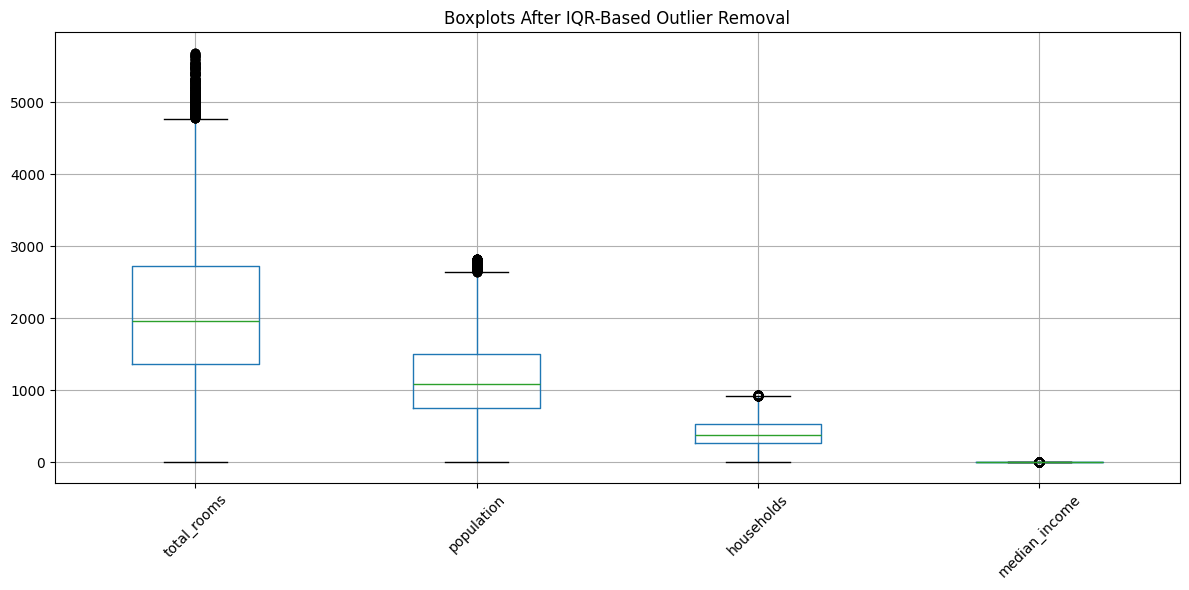

In [27]:
plt.figure(figsize=(12, 6))
df_iqr_removed[outlier_features].boxplot(rot=45)
plt.title("Boxplots After IQR-Based Outlier Removal")
plt.tight_layout()
plt.show()

### Observations After IQR-Based Outlier Removal (Boxplots)

- Extreme high-value outliers across all selected features have been **significantly reduced**, resulting in more compact and interpretable distributions.
- The interquartile ranges are now **narrower**, indicating lower variance and reduced influence of extreme observations.
- **`total_rooms`** and **`population`** still show mild upper-tail dispersion, suggesting natural variability rather than noise.
- **`households`** now exhibit more balanced distributions with fewer high-leverage points.
- **`median_income`** remains largely unchanged, reinforcing that its earlier extremes were driven by an upper cap rather than true anomalies.

Overall, IQR-based removal successfully stabilizes the feature distributions, but this comes at the cost of **discarding a meaningful portion of the data**, which may impact the model’s ability to generalize to high-density or high-income regions.

## 3. Baseline Model Comparison (With vs Without Outlier Removal)

Visual improvements do not always translate into better model performance.  
To evaluate the real impact of IQR-based outlier removal, we train the same regression model on:

1. The original dataset (no outlier handling)
2. The dataset after IQR-based outlier removal

Both models are evaluated using identical metrics to ensure a fair comparison.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [29]:
features = outlier_features + ["housing_median_age"]
target = "median_house_value"

In [32]:
def train_evaluate_model(df, features, target):
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return rmse, mae, r2

In [33]:
baseline_metrics = train_evaluate_model(df, features, target)
iqr_metrics = train_evaluate_model(df_iqr_removed, features, target)

baseline_metrics, iqr_metrics

((np.float64(76876.05638105121), 56722.434316338375, 0.5490012551168503),
 (np.float64(70809.51639942234), 53645.86065842848, 0.5642712762125578))

### Observations from Baseline vs IQR-Removed Model Performance

After applying IQR-based outlier removal, the model shows a noticeable improvement across all evaluation metrics. The RMSE decreases, indicating reduced sensitivity to extreme prediction errors, while MAE also drops, suggesting more consistent and reliable predictions on average. Additionally, the R² score improves, implying that the model trained on the cleaned dataset explains a higher proportion of variance in house prices. This indicates that extreme outliers were negatively impacting the baseline model’s learning process. However, the improvement comes at the cost of removing a significant portion of the data, highlighting an important trade-off: while outlier removal can enhance model performance, it may also reduce the model’s exposure to rare but valid high-value scenarios. These results motivate exploring less destructive alternatives such as outlier capping and data transformation.

## 4. Outlier Capping (Winsorization)

Outlier capping limits the influence of extreme values **without removing any rows** from the dataset.  
Instead of discarding data, values beyond a defined threshold are **clipped** to upper and lower bounds.

This approach aims to:
- Preserve all observations
- Reduce the dominance of extreme values
- Improve model stability while maintaining representativeness

In [34]:
def cap_outliers_iqr(df, columns):
    df_capped = df.copy()
    
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
        
    return df_capped

In [35]:
df_capped = cap_outliers_iqr(df_dropped, outlier_features)

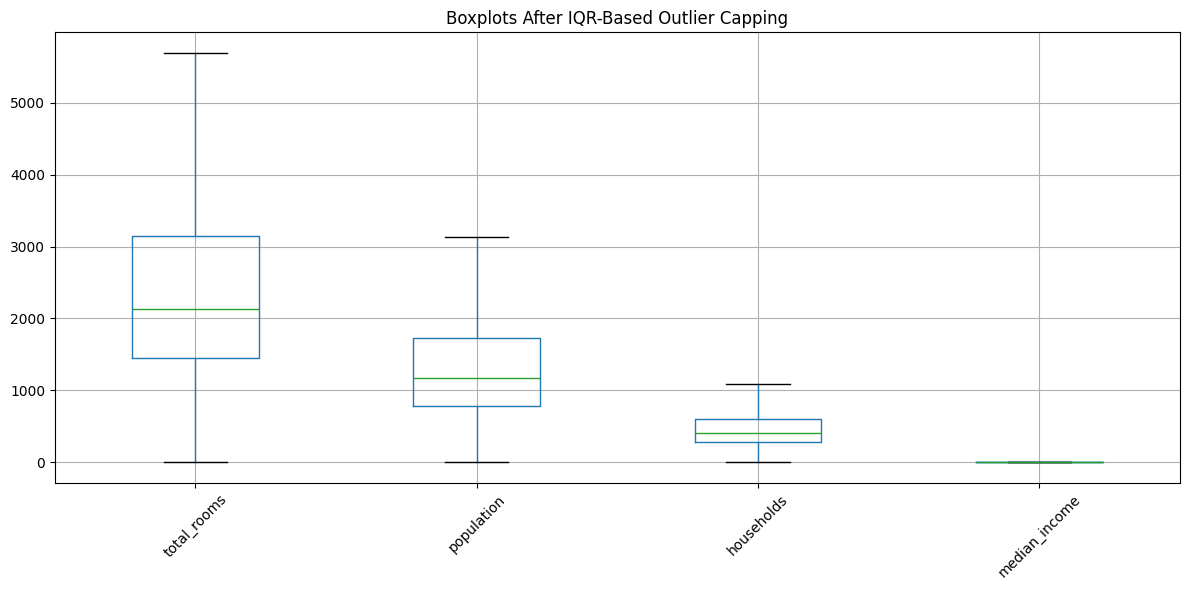

In [36]:
plt.figure(figsize=(12, 6))
df_capped[outlier_features].boxplot(rot=45)
plt.title("Boxplots After IQR-Based Outlier Capping")
plt.tight_layout()
plt.show()

### Observations After IQR-Based Outlier Capping

Outlier capping successfully limits extreme values across all features while preserving the original data points. The distributions become more compact with reduced upper tails, especially for `total_rooms` and `population`. Unlike outlier removal, no data is lost, making capping a balanced approach that reduces the influence of extreme values without sacrificing dataset representativeness.

## 5. Outlier Handling via Data Transformation
Instead of removing or capping extreme values, data transformation reshapes feature distributions to **reduce skewness and stabilize variance**.  
This allows models to learn from all data points while minimizing the dominance of extreme values. In this step, we apply **log transformation** to heavily right-skewed features and evaluate its impact on model performance.

In [37]:
def log_transform(df, columns):
    df_transformed = df.copy()
    
    for col in columns:
        df_transformed[col] = np.log1p(df_transformed[col])
        
    return df_transformed

In [38]:
df_log_transformed = log_transform(df_dropped, outlier_features)

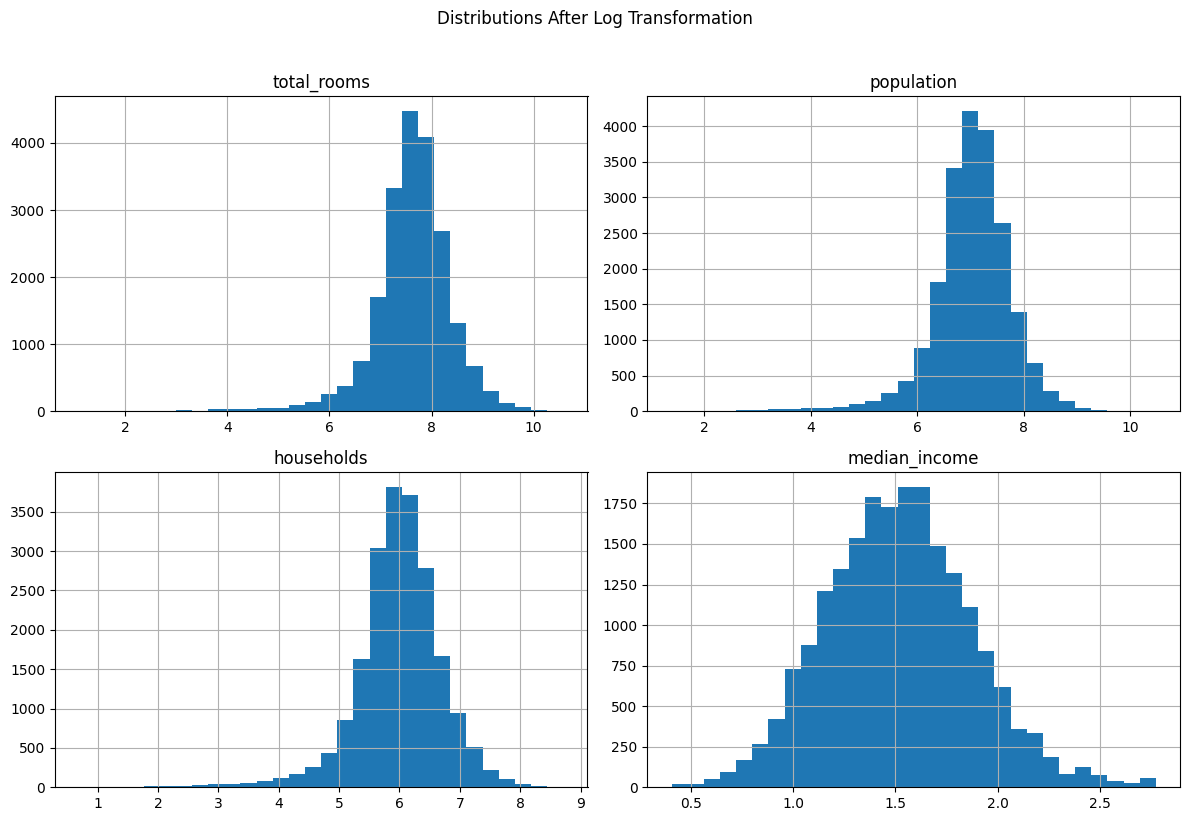

In [39]:
df_log_transformed[outlier_features].hist(figsize=(12, 8),bins=30)
plt.suptitle("Distributions After Log Transformation", y=1.02)
plt.tight_layout()
plt.show()

### Observations After Log Transformation

Log transformation significantly reduces right skewness across all selected features, resulting in more symmetric and bell-shaped distributions. Extreme values are compressed rather than removed, allowing the model to retain information from high-value observations without letting them dominate the scale. Overall, the transformed features exhibit improved distributional balance, making them better suited for linear modeling while preserving the full dataset.

In [40]:
log_metrics = train_evaluate_model(df_log_transformed, features, target)

log_metrics

(np.float64(77091.40465319395), 58053.01542390339, 0.5464710048476222)

### Observations from Log-Transformed Model Performance

The model trained on log-transformed features shows a reduction in RMSE and MAE compared to the baseline model, indicating improved error stability and reduced sensitivity to extreme values. However, the R² score remains largely unchanged, suggesting that while log transformation helps control variance and scale, it does not significantly increase the model’s explanatory power. This indicates that transformation primarily improves prediction consistency rather than uncovering additional linear relationships in the data.

##  Updated Final Performance Comparison

| Outlier Strategy | RMSE | MAE | R² |
|-----------------|------|-----|----|
| No Handling | 76,876 | 56,722 | 0.549 |
| Removal (IQR) | 70,810 | 53,646 | 0.564 |
| Log Transformation | 77,091 | 58,053 | 0.547 |


## Comparative Insight

Among the evaluated strategies, IQR-based outlier removal delivers the strongest numerical improvement in error metrics but at the cost of losing a significant portion of the data. Log transformation improves distributional symmetry and stabilizes errors but does not outperform outlier removal in terms of predictive accuracy. This highlights that transformation is more effective as a variance-stabilization technique than as a performance-boosting method for linear models in this context.

## Final Takeaway

This case study demonstrates that the effectiveness of outlier handling depends on the intended trade-off between model performance and data preservation. While aggressive techniques like outlier removal can enhance accuracy, they may sacrifice representativeness. Log transformation offers a safer, non-destructive alternative but may yield limited gains in explanatory power. As a result, outlier handling decisions should always be validated through modeling rather than applied blindly during preprocessing.